In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
ax = rc("font", family="serif", size=11)

We shall create an oscillating signal with an exponentially decaying component, which will then have some Gaussian noise applied to it. This can be represented using the following equation

$$ y\left(t\right) = \alpha\sin\left(\omega t\right)e^{-2\beta t} $$

We shall choose some initial values of $\alpha=10$, $\beta=0.1$; with a angular frequency of $\omega = \frac{20}{2\pi}$.

In [65]:
N = 360
C = 5      # Defines length of data in integers of 2*pi
alpha = 10
beta = 0.1

t = np.linspace(0, np.pi*C, N)
frequency = 20
omega = frequency/(2*np.pi)


def sine(t,alpha,omega):
    return alpha*np.sin(omega*t)
def expn(t,beta):
    return np.exp(-2 * beta * t)

decay = sine(t,alpha,omega) * expn(t,beta)

f_sg = 1
f_true = np.random.randn(N) * f_sg + decay
f_obs_sg = np.ones(N) * 2
f_obs = f_true + np.random.randn(N) * f_obs_sg

With the noise added to our data, let's plot it to see its effect and see what we will be aiming to make inferences from. 

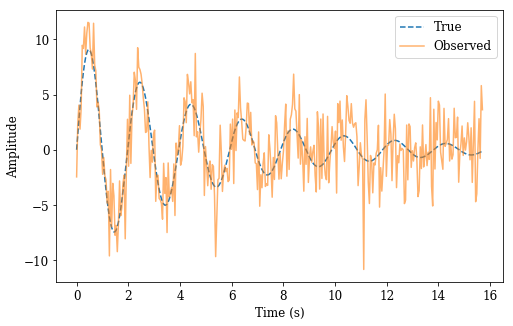

In [71]:
plt.figure(1, figsize=(8,5))
plt.plot(t, decay, '--', label=('True'))
plt.plot(t, f_obs, alpha=0.6, label=('Observed'))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Now let's introduce and implement our Stan code.

In [72]:
code = '''
functions {
    real sine(real omega, real alpha, real t){
        return alpha * sin(omega*t);
    }
    real expn(real t, real beta){
        return exp(-2 * beta * t);
    }
}
data {
    int N;
    real t[N];
    real f[N];
    real f_unc[N];
}
parameters {
    real<lower = 0> omega;
    real<lower = 0> beta;
    real ln_height;

}
transformed parameters {
    real height;
    height = exp(ln_height);
}
model {

    real mod[N];
    for (i in 1:N){
        mod[i] = sine(omega, height, t[i]) * expn(t[i], beta);
    }
    mod ~ normal(f,f_unc);
    omega ~ normal(3.18, 2.0);
    height ~ normal(10.0, 0.3);
    beta ~ normal(0.1,0.05);
    // f_unc ~ lognormal(2.0, 1.0);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ddd709368869dbf93c34e3324b8fbb78 NOW.


In [77]:
stan_data = {'N': len(t),
             't': t, 
             'f': f_obs,
             'f_unc': f_obs_sg}
start = {'omega': 3.18}
nchains = 4
fit = sm.sampling(data=stan_data, iter=1000, chains=nchains, init=[start for n in range(nchains)])

In [78]:
print(fit)

Inference for Stan model: anon_model_ddd709368869dbf93c34e3324b8fbb78.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
omega       3.19  2.1e-4   0.01   3.17   3.18   3.19   3.19   3.21   2518    1.0
beta         0.1  1.8e-4 6.0e-3   0.09    0.1    0.1    0.1   0.11   1125    1.0
ln_height   2.31  7.8e-4   0.03   2.26    2.3   2.31   2.33   2.36   1084    1.0
height     10.11  7.8e-3   0.26   9.57   9.95  10.12  10.29  10.61   1088    1.0
lp__      -248.6    0.04    1.2 -251.6 -249.2 -248.3 -247.7 -247.2    729    1.0

Samples were drawn using NUTS at Mon Nov 19 19:35:29 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


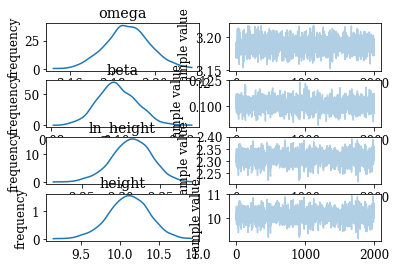

In [79]:
fit.plot()
plt.show()

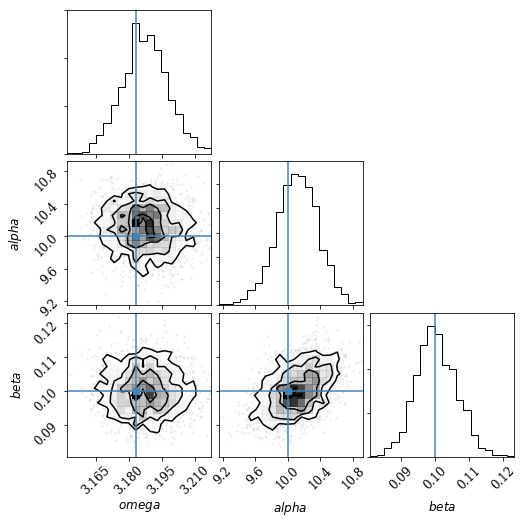

In [82]:
import corner
rc("font", family="serif", size=12)
data = np.vstack([fit['omega'], np.exp(fit['ln_height']), fit['beta']]).T
corner.corner(data, labels=[r'$omega$', r'$alpha$', r'$beta$'], truths=[omega, alpha, beta])
plt.show()

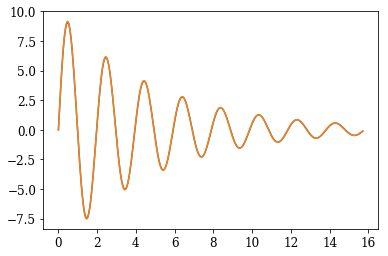

In [83]:
plt.plot(t, decay)
plt.plot(t, sine(t, np.exp(fit['ln_height'].mean()), fit['omega'].mean()) * expn(t, fit['beta'].mean()))